<a href="https://colab.research.google.com/github/blueberrycrumble/AIFFEL_quest_cr/blob/master/Datathon/hypothesis2_DOTT_DatathonOTT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')

### 원본 데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 평점 데이터
imdb_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Toy Datasets/rating_netflix_with_imdb.csv')
disney_rating_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Toy Datasets/disney_with_imdb.csv')

# 평점 데이터 클린업 후 합치기

# 원 데이터셋
amazon_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Toy Datasets/amazon_prime_titles.csv')
netflix_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Toy Datasets/netflix_titles.csv')
disney_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Toy Datasets/disney_plus_titles.csv')

In [ ]:
# 컬럼 이름을 소문자로 통일
netflix_df.columns = netflix_df.columns.str.lower()
amazon_df.columns = amazon_df.columns.str.lower()
disney_df.columns = disney_df.columns.str.lower()

# 공통 컬럼만 추출
common_cols = ['type', 'title', 'director', 'cast', 'listed_in','release_year']
netflix_df = netflix_df[common_cols]
amazon_df = amazon_df[common_cols]
disney_df = disney_df[common_cols]

# 출처 플랫폼 컬럼 추가
netflix_df['platform'] = 'Netflix'
amazon_df['platform'] = 'Amazon'
disney_df['platform'] = 'Disney'

netflix_df.describe()
disney_df.describe()
amazon_df.describe()


In [ ]:
# Netflix missing value
for i in range(len(netflix_df.isnull().sum())):
    if netflix_df.isnull().sum()[i] > 0:
        print('Netflix | Total Number of missing values in ' + netflix_df.isnull().sum().index[i] + ' : ',netflix_df.isnull().sum()[i])

# Disney missing value
for i in range(len(disney_df.isnull().sum())):
    if disney_df.isnull().sum()[i] > 0:
        print('Disney  | Total Number of missing values in ' + disney_df.isnull().sum().index[i] + ' : ',disney_df.isnull().sum()[i])

# Amazon missing value
for i in range(len(amazon_df.isnull().sum())):
    if amazon_df.isnull().sum()[i] > 0:
        print('Amazon  | Total Number of missing values in ' + amazon_df.isnull().sum().index[i] + ' : ',amazon_df.isnull().sum()[i])

In [ ]:
# title 컬럼에서 None 또는 NaN 값이 있는 행 찾기
pd.concat([amazon_df.isnull().sum().rename('Amazon'),disney_df.isnull().sum().rename('Disney'),netflix_df.isnull().sum().rename('Netflix')],axis=1).T

In [ ]:
# # 넷플릭스 데이터 결측치와 고유값 확인
netflix_df[['director','cast']] = netflix_df[['director','cast']].fillna('Unknown')

# # 디즈니 데이터 결측치와 고유값 확인
disney_df[['director','cast']] = disney_df[['director','cast']].fillna('Unknown')

# 아마존 데이터 결측치와 고유값 확인
amazon_df[['director','cast']] = amazon_df[['director','cast']].fillna('Unknown')
pd.concat([amazon_df.nunique().rename('amazon'),disney_df.nunique().rename('disney'),netflix_df.nunique().rename('netflix')], axis=1).T


### 데이터 클린업

In [ ]:
# title 문자열 정리

def clean_and_split_title(title):

    processed_title = re.sub('[^0-9a-zA-Z]+', '', title)

    # 영어와 외국어 분리 (영어가 아니면 None로 저장)
    if len(processed_title) > 0:
        return processed_title
    else:
        return None

# 세 데이터셋의 타이틀에 변환 적용
netflix_df['title'] = netflix_df['title'].apply(lambda x: pd.Series(clean_and_split_title(x)))
disney_df['title'] = disney_df['title'].apply(lambda x: pd.Series(clean_and_split_title(x)))
amazon_df['title'] = amazon_df['title'].apply(lambda x: pd.Series(clean_and_split_title(x)))
imdb_df['title'] = imdb_df['title'].apply(lambda x: pd.Series(clean_and_split_title(x)))
disney_rating_df['title'] = disney_rating_df['title'].apply(lambda x: pd.Series(clean_and_split_title(x)))

In [ ]:
# title 컬럼에서 None 또는 NaN 값이 있는 행 찾기
pd.concat([amazon_df.isnull().sum().rename('Amazon'),
           disney_df.isnull().sum().rename('Disney'),
           netflix_df.isnull().sum().rename('Netflix'),
           imdb_df.isnull().sum().rename('imdb'),
           disney_rating_df.isnull().sum().rename('disney_rating')],axis=1).T

In [ ]:
# 넷플릭스의 영화 제목에 결측치 10개 = 외국어 제목을 가져서 Null처리한 영화
netflix_df = netflix_df.dropna(subset = ['title'])
disney_df = disney_df.dropna(subset = ['title'])
amazon_df = amazon_df.dropna(subset = ['title'])
imdb_df = imdb_df.dropna(subset = ['title'])
disney_rating_df = disney_rating_df.dropna(subset = ['title'])

# title 컬럼에서 None 또는 NaN 값이 있는 행 찾기
pd.concat([amazon_df.isnull().sum().rename('Amazon'),
           disney_df.isnull().sum().rename('Disney'),
           netflix_df.isnull().sum().rename('Netflix'),
           imdb_df.isnull().sum().rename('imdb'),
           disney_rating_df.isnull().sum().rename('disney_rating')],axis=1).T

In [ ]:
# 결과 확인: 타이틀이 정리되었음
netflix_df.head(100)


In [ ]:
from sklearn.cluster import KMeans

# 3사 데이터셋 합치기. title, director, release_year 가 매칭되는 중복 데이터 드롭하기
combined_df = pd.concat([netflix_df, amazon_df, disney_df], axis = 0).sort_values('title')
combined_df = combined_df.drop_duplicates(subset = ['title', 'director', 'release_year'], keep = 'first')

# 외부 데이터셋의 imdb_rating 의 컬럼을 3사 데이터셋에 합치되, title director release_year를 기준으로 매칭되는 데이터인지 확인하고, imdb_rating 컬럼만 추가
combined_df = combined_df.merge(imdb_df[['title', 'director', 'release_year', 'imdb_rating']], on = ['title', 'director', 'release_year'], how = 'left')
# 외부 데이터셋 2: 다른 imdb_ratng을 추가할 때는 기존의 평점 데이터와 분리해서 먼저 imdb_rating_REMOVE에 담고, Null이 아닌 값만 imdb_rating 컬럼에 업데이트 해준다.
combined_df = combined_df.merge(disney_rating_df[['title', 'director', 'release_year', 'imdb_rating']], on = ['title', 'director', 'release_year'], how = 'left', suffixes = ['', '_REMOVE'])
combined_df['imdb_rating'] = combined_df['imdb_rating_REMOVE'].combine_first(combined_df['imdb_rating'])
combined_df = combined_df.drop(columns = ['imdb_rating_REMOVE'], axis = 1).drop_duplicates()


In [ ]:
# 같은 영화에 출연한 배우(cast 컬럼의 리스트)를 여러 행으로 확장
combined_df['cast'] = combined_df['cast'].apply(lambda x: str(x).split(', '))
combined_df = combined_df.explode('cast')
# factorize 는 텍스트 데이터를 정수로 인코딩하기 위해 사용됨
combined_df['cast_id'] = combined_df['cast'].factorize()[0]
combined_df['director_id'] = combined_df['director'].factorize()[0]
combined_df['platform_id'] = combined_df['platform'].factorize()[0]

# 리스트로 묶인 세분화된 영화의 장르를 군집화하여 추려내기 위헌 Cluster 알고리즘
# 적합한 n_clusters 수치를 찾기위해 silhouette_score 를 활용할 예정
kmeans = KMeans(n_clusters=120, random_state=42)
combined_df['listed_in_id'] = kmeans.fit_predict(TfidfVectorizer().fit_transform(combined_df['listed_in']))

combined_df

### 특정 배우가 출연한 imdb 점수와 일반적인 영화들의 imdb 점수 비교

#### 디카프리오

In [ ]:
combined_df[combined_df.cast == 'Leonardo DiCaprio']

In [ ]:
combined_df


편향이 존재하는 그래프  


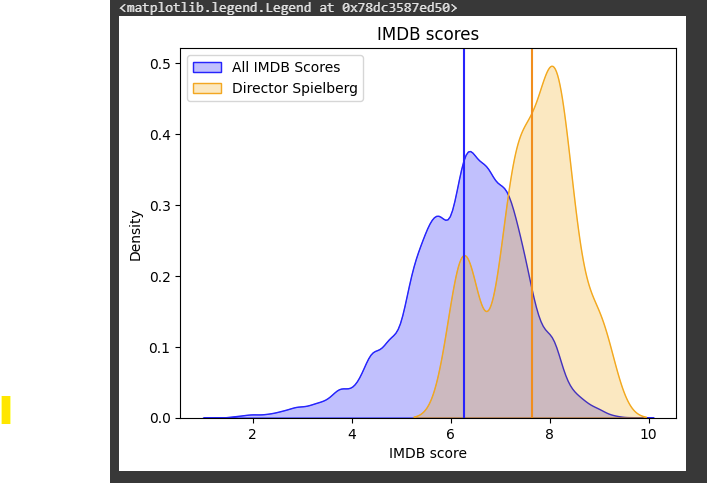

편향을 제거한 그래프  

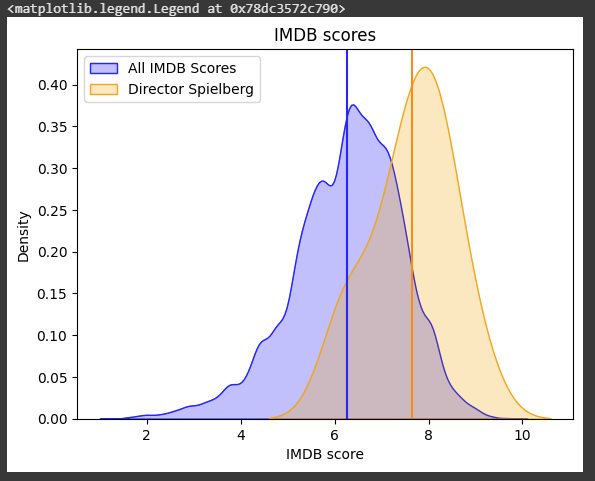

##### 스필버그 그래프

In [ ]:
from scipy.stats import ks_2samp

all_movies = combined_df.drop_duplicates(subset = ['title', 'release_year']).dropna(subset = ['imdb_rating'])
spielberg = combined_df[combined_df.director == 'Steven Spielberg'].drop_duplicates(subset = ['title', 'release_year']).dropna(subset = ['imdb_rating']).dropna()
spielberg_actors = combined_df[combined_df.cast.isin(combined_df[combined_df.director == 'Steven Spielberg'].cast.unique())] # 스필버그와 함께 일한 이력이 있는 모든 배우들
spielberg_actors_without_spielberg = spielberg_actors[spielberg_actors.director != 'Steven Spielberg']

# pvalue = ks_2samp(spielberg_actors['imdb_rating'].dropna(),spielberg_actors_without_spielberg['imdb_rating'].dropna()).pvalue


fig, ax = plt.subplots(figsize = (15, 7))
# ax.set_title(f'Spielberg effect, two-sided kstest p-value: {pvalue:.3f}')
ax.set_title(f'Spielberg effect')
#ax.set_title(f'IMDB scores')
ax.set_xlabel('IMDB score')
ax.set_ylabel('Density')
sns.kdeplot(ax=ax, data=all_movies, x='imdb_rating', fill=True, alpha = 0.05, color='blue',label=f'All IMDB Scores (n_movies = {all_movies.shape[0]})')
# sns.kdeplot(ax=ax, data=spielberg, x='imdb_rating', fill=True, color='orange', alpha = 0.1, label=f'Director Spielberg (n_movies = {spielberg.shape[0]})')
# sns.kdeplot(ax=ax, data=spielberg_actors.dropna(subset = ['imdb_rating']), x='imdb_rating', fill=True, color='green',label=f'Spielberg\'s actors scores (n_actors = {spielberg_actors.cast.nunique()}), n_movies = {spielberg_actors.cast.count()})')
# sns.kdeplot(ax=ax, data=spielberg_actors_without_spielberg.dropna(subset = ['imdb_rating']), x='imdb_rating', fill=True, color='red',label=f'Spielberg\'s actors scores without maestro  (n_actors = {spielberg_actors_without_spielberg.cast.nunique()}), n_movies = {spieliberg_actors_without_spielberg.cast.count()})')




# lines show the mean of distributions
ax.axvline(all_movies['imdb_rating'].mean(),color='blue')
# ax.axvline(spielberg['imdb_rating'].mean(),color='darkorange')
# ax.axvline(spielberg_actors['imdb_rating'].dropna().mean(),color='green')
# ax.axvline(spielberg_actors_without_spielberg['imdb_rating'].dropna().mean(),color='red')
ax.legend()


# 스필버그 이펙트: 스필버그의 영화가 배우들의 커리어에 미치는 영향을 재미로 살펴보자!
# 스필버그와 같이 일했던 배우들은 일반 배우들에 비해 전체 필모에서 높은 imdb 점수의 경향을 보이는가?
# 높은 스코어를 보인 레오나르도를 스필버그의 데이터에서 제외하고, 스필버그 영화에 출연한 다른 배우들의 데이터를 대조하면, 스필버그 감독의 영향력이 레오나르도의 스코어에 미치는 영향을 볼 수 있지 않을까?
# 스필버그 영화에 출연한 배우들의 imdb 점수가 스필버그 영화에 출연한 이전/이후

# 편향:
# 1) 유명 감독일 수록 데이터량이 많음
# 2) cast 멤버를 개별 행으로 분리했기 때문에 imdb 스코어가 낮은 영화에 캐스트 멤버가 많을 경우 상단 그래프와 같은 구멍이 발생함.
# 수정된 그래프는 2번 편향을 제거하여 신뢰도가 있음

In [ ]:
spieliberg_actors_without_spielberg

#### exploration

In [ ]:
director_scores = {}
for _, group in combined_df[combined_df.cast != 'Unknown'].drop_duplicates(subset = ['director', 'title']).groupby('director'):
    director_scores[group.director.iloc[0]] = group.imdb_rating.dropna().mean()
director_scores = pd.Series(director_scores, name = 'imdb_rating_mean').sort_values().dropna()

horrible_director = director_scores.index[100]
horrible_director_actors = combined_df[combined_df.cast.isin(combined_df[combined_df.director == horrible_director].cast.unique())] # 스필버그와 함께 일한 이력이 있는 모든 배우들
horrible_director_without_himher = horrible_director_actors[horrible_director_actors.director != horrible_director]


fig, ax = plt.subplots(figsize = (15, 7))
# ax.set_title(f'IMDB scores, kstest pvalue: {pvalue:.3f}')
ax.set_title(f'IMDB scores')
ax.set_xlabel('IMDB score')
ax.set_ylabel('Density')
# ax.hist(df_merged['imdb_rating'], bins=30,color='blue',density=True,alpha=0.5,label='all imdb scores')
# ax.hist(df_leo['imdb_rating'],bins=30,color='orange',density=True,alpha=0.5,label='leo imdb')
sns.kdeplot(ax=ax, data=combined_df.drop_duplicates(subset = ['title', 'release_year']).dropna(subset = ['imdb_rating']), x='imdb_rating', fill=True, alpha = 0.05, color='blue',label='All IMDB Scores')
sns.kdeplot(ax=ax, data=combined_df[combined_df.director == horrible_director].drop_duplicates(subset = ['title', 'release_year']).dropna(subset = ['imdb_rating']), x='imdb_rating', fill=True, color='orange', alpha = 0.1, label='Director Spielberg')
sns.kdeplot(ax=ax, data=horrible_director_actors.dropna(subset = ['imdb_rating']), x='imdb_rating', fill=True, color='green',label='Horrible director\'s actors scores')
sns.kdeplot(ax=ax, data=horrible_director_without_himher.dropna(subset = ['imdb_rating']), x='imdb_rating', fill=True, color='red',label='Horribe director\'s actors scores without maestro')




# lines show the mean of distributions
ax.axvline(combined_df.drop_duplicates(subset = ['title', 'release_year'])['imdb_rating'].dropna().mean(),color='blue')
ax.axvline(combined_df[combined_df.director == 'Los Horriblos'].drop_duplicates(subset = ['title', 'release_year'])['imdb_rating'].dropna().mean(), color='darkorange')
ax.axvline(horrible_director_actors['imdb_rating'].dropna().mean(),color='green')
ax.axvline(horrible_director_without_himher['imdb_rating'].dropna().mean(),color='red')
ax.legend()


# 스필버그 이펙트: 스필버그의 영화가 배우들의 커리어에 미치는 영향을 재미로 살펴보자!
# 스필버그와 같이 일했던 배우들은 일반 배우들에 비해 전체 필모에서 높은 imdb 점수의 경향을 보이는가?
# 높은 스코어를 보인 레오나르도를 스필버그의 데이터에서 제외하고, 스필버그 영화에 출연한 다른 배우들의 데이터를 대조하면, 스필버그 감독의 영향력이 레오나르도의 스코어에 미치는 영향을 볼 수 있지 않을까?
# 스필버그 영화에 출연한 배우들의 imdb 점수가 스필버그 영화에 출연한 이전/이후

# 편향:
# 1) 유명 감독일 수록 데이터량이 많음
# 2) cast 멤버를 개별 행으로 분리했기 때문에 imdb 스코어가 낮은 영화에 캐스트 멤버가 많을 경우 상단 그래프와 같은 구멍이 발생함.
# 수정된 그래프는 2번 편향을 제거하여 신뢰도가 있음

In [ ]:
combined_df[combined_df.director == horrible_director]#.drop_duplicates(subset = ['title', 'release_year']).dropna(subset = ['imdb_rating'])


In [ ]:
horrible_director_actors

##### 레오나르도 그래프

In [ ]:
from scipy.stats import ks_2samp

pvalue = ks_2samp(df_merged['imdb_rating'].dropna(),df_leo['imdb_rating'].dropna()).pvalue


fig, ax = plt.subplots()
ax.set_title(f'IMDB scores, kstest pvalue: {pvalue:.3f}')
ax.set_xlabel('IMDB score')
ax.set_ylabel('Density')
# ax.hist(df_merged['imdb_rating'], bins=30,color='blue',density=True,alpha=0.5,label='all imdb scores')
# ax.hist(df_leo['imdb_rating'],bins=30,color='orange',density=True,alpha=0.5,label='leo imdb')
sns.kdeplot(ax=ax, data=combined_df, x='imdb_rating', fill=True, color='blue',label='All IMDB Scores')
sns.kdeplot(ax=ax, data=df_leo, x='imdb_rating', fill=True, color='orange',label='DiCaprio')

# lines show the mean of distributions
ax.axvline(df_merged['imdb_rating'].dropna().mean(),color='blue')
ax.axvline(df_leo['imdb_rating'].dropna().mean(),color='darkorange')
ax.legend()



In [ ]:
from scipy.stats import ks_2samp

ks_2samp(df_merged['imdb_rating'].dropna(),df_leo['imdb_rating'].dropna()).pvalue

#### kmeans clustering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['listed_in'])
X
# K-Means 클러스터링 (예: 8개의 주요 장르 그룹)

scores=[]
for n_cluster in np.arange(30, 50, 5):

    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    scores.append(silhouette_score(X,kmeans.fit_predict(X)))
    print(scores)

# df['genre_cluster'] = kmeans.fit_predict(X)
# kmeans.fit_predict(X)
# X.todense()

- TF-IDF 공백으로 단어를 구분하고 바이너리 인코딩  
    TF: 용어 빈도 계산  
    IDF: 역문서빈도 계산
- K-means 알고리즘
가깝게 위치하는 데이터를 비슷한 특성을 지닌 데이터로 여기고 같은 군집으로 군집화(clustering)



In [ ]:
kmeans = KMeans(n_clusters=120, random_state=42)
df['listed_in_id'] = kmeans.fit_predict(X)

In [ ]:
df[~df.duplicated('show_id')].head(100)

In [ ]:
# ML 인풋 데이터셋 생성
# zsample weight이 중요하다!


X_train = df.dropna(subset=['imdb_rating'])
sample_weight = X_train.title.map(1/X_train.title.value_counts())

y_train = X_train['imdb_rating']
X_train = X_train[['type_id','director_id','platform_id','listed_in_id']]
X_test = df[df['imdb_rating'].isnull()][['type_id','director_id','platform_id','listed_in_id']]
X_test

sample_weight.shape, X_train.shape, y_train.shape

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score
# groups=X_train.index
print(cross_val_score(HistGradientBoostingRegressor(max_iter=100, max_depth=10, early_stopping=False), X_train, y_train, groups=X_train.index, params={'sample_weight': sample_weight}),) # model, x, y as parameter
model = HistGradientBoostingRegressor(max_iter=100, max_depth=10, early_stopping=False)
model.fit(X_train,y_train, sample_weight=sample_weight )
,
# 결과값이 1에 가까울 수록 높은 예측률(현실적으로 0.3 정도만 되어도 괜찮은 결과라고 봄) -1에 가까울 수록 바보 모델

In [ ]:
model.predict(X_test)

In [ ]:
fig,ax = plt.subplots()
ax.scatter(y_train, model.predict(X_train), s=3)
# 대각선 선형이어야 하는데 모델이 아주 구림을 증명

#### 네트워크 그래프

In [ ]:
# test

import networkx as nx
import re

# 예제 데이터 (같은 감독-배우 조합이 여러 영화에서 등장)

# Test용 DataFrame 생성
df_test = df

# 🔹 NaN 값 처리 (빈 문자열로 변환 후 문자열 타입 변환)
df_test['director'] = df_test['director'].fillna('').astype(str)
df_test['cast'] = df_test['cast'].fillna('').astype(str)

# 🔹 특수 문자 제거 함수
def clean_text(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)  # 영문, 숫자, 공백만 남기기

# 🔹 감독 및 배우 컬럼 정리
df_test['director'] = df_test['director'].apply(clean_text)
df_test['cast'] = df_test['cast'].apply(clean_text)

# 감독-배우 협업 횟수 계산
df_grouped = df_test.groupby(['director', 'cast']).size().reset_index(name='weight')

# 네트워크 그래프 생성
G = nx.Graph()

# 감독과 배우 관계 추가 (가중치 포함)
for _, row in df_grouped.iterrows():
    G.add_edge(row['director'], row['cast'], weight=row['weight'])  # 협업 횟수를 weight로 설정

# 그래프 시각화
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)  # 노드 배치

# 가중치 기반으로 엣지 두께 설정
edges = G.edges(data=True)
weights = [d['weight'] * 0.01 for (_, _, d) in edges]  # 가중치를 2배로 확대해 강조

# 노드 및 엣지 그리기
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=30, font_size=5, font_weight="bold", width=weights)

# 그래프 제목
plt.title("Weighted Director-Actor Collaboration Graph")
plt.show()
